## Lasso

In [7]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


In [8]:
###############################################################################
# Figure configuration
import matplotlib as mpl
plt.rcParams['figure.figsize'] = (16, 6)

###############################################################################
# Load and Define dataset:
start_date = datetime(2023,1,1)
end_date = datetime(2023,10,31)
DATA_raw = pd.read_csv('META_FeatureMart.csv', index_col = [0])
DATA_raw.describe()

,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,OBMMIJUMBO30YF,...,USRECDM,USRECDP,META_OPEN,META_HIGH,META_LOW,META_CLOSE,META_ADJ CLOSE,META_VOLUME,META_DAILY_RETURN,META_RSI
count,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1707.000000,1703.000000,...,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1.719000e+03,1718.000000,1706.000000
mean,0.030762,-0.019622,-0.010803,0.019593,0.000518,0.006341,-0.230073,3398.195526,0.590410,4.464628,...,0.023851,0.023851,212.400797,215.242688,209.693514,212.509506,212.509506,2.326401e+07,0.000882,53.841355
std,1.012749,0.427571,0.649191,0.295106,0.406601,0.007070,3.433184,742.616015,0.948556,1.235386,...,0.152629,0.152629,66.179199,66.939812,65.344233,66.125886,66.125886,1.569313e+07,0.025481,12.426797
min,-9.620000,-5.270000,-3.100000,-1.510000,-1.910000,0.000000,-26.323300,2237.400000,-1.890000,2.812000,...,0.000000,0.000000,90.080002,90.459999,88.089996,88.910004,88.910004,6.046300e+06,-0.263901,21.934202
25%,-0.380000,-0.250000,-0.330000,-0.160000,-0.210000,0.000000,-0.344032,2744.590000,0.110000,3.501000,...,0.000000,0.000000,165.914993,168.315002,163.750000,166.010002,166.010002,1.462365e+07,-0.009615,45.509678
50%,0.050000,-0.010000,-0.050000,0.030000,-0.030000,0.010000,-0.069850,3236.920000,0.810000,4.205000,...,0.000000,0.000000,189.000000,191.380005,186.539993,188.889999,188.889999,1.934310e+07,0.000952,53.903732
75%,0.510000,0.200000,0.300000,0.200000,0.190000,0.010000,0.277293,4121.950000,1.280000,4.855000,...,0.000000,0.000000,265.539993,269.005005,261.745010,265.139999,265.139999,2.666330e+07,0.012899,63.089314
max,8.330000,2.000000,4.160000,1.510000,1.880000,0.020000,9.365240,4796.560000,2.270000,8.232000,...,1.000000,1.000000,381.679993,384.329987,378.809998,382.179993,382.179993,2.323166e+08,0.232824,89.804124


In [9]:
DATA_raw.head()

,DATE,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,...,USRECDM,USRECDP,META_OPEN,META_HIGH,META_LOW,META_CLOSE,META_ADJ CLOSE,META_VOLUME,META_DAILY_RETURN,META_RSI
0,1/3/2017,0.53,-0.24,0.33,-0.28,0.11,0.0,0.199210,2257.83,1.92,...,0,0,116.029999,117.839996,115.510002,116.860001,116.860001,20663900,NaN,NaN
1,1/4/2017,1.03,0.51,0.29,-0.37,-0.10,0.0,0.178190,2270.75,1.93,...,0,0,117.550003,119.660004,117.290001,118.690002,118.690002,19630900,0.015660,NaN
2,1/5/2017,0.50,0.02,-0.36,0.02,-0.15,0.0,0.157624,2269.00,1.85,...,0,0,118.860001,120.949997,118.320000,120.669998,120.669998,19492200,0.016682,NaN
3,1/6/2017,-0.24,-0.52,-0.49,-0.06,-0.16,0.0,0.137503,2276.98,1.89,...,0,0,120.980003,123.879997,120.029999,123.410004,123.410004,28545300,0.022707,NaN
4,1/9/2017,-0.11,0.04,-0.61,0.32,-0.34,0.0,0.079457,2268.90,1.88,...,0,0,123.550003,125.430000,123.040001,124.900002,124.900002,22880400,0.012074,NaN


In [35]:
start_date = datetime(2023,1,1)
end_date = datetime(2023,10,31)
DATA_raw['DATE'] = pd.to_datetime(DATA_raw['DATE'])
mask = (DATA_raw['DATE'] >= start_date) & (DATA_raw['DATE'] <= end_date)
DATA_raw = DATA_raw.loc[mask]
DATA_raw.reset_index(drop = True, inplace = True)
DATA_raw

,DATE,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,...,USRECDM,USRECDP,META_OPEN,META_HIGH,META_LOW,META_CLOSE,META_ADJ CLOSE,META_VOLUME,META_DAILY_RETURN,META_RSI
0,2023-01-03,-0.38,-0.11,-0.06,-0.25,0.32,0.02,0.045713,3824.14,-0.74,...,0,0,122.820000,126.370003,122.279999,124.739998,124.739998,35528500,0.036563,60.008232
1,2023-01-04,0.90,-0.41,0.05,-0.74,-0.14,0.02,0.089794,3852.97,-0.86,...,0,0,127.379997,129.050003,125.849998,127.370003,127.370003,32397100,0.021084,62.736570
2,2023-01-05,-0.98,0.22,0.69,0.18,0.49,0.02,0.131008,3808.10,-0.95,...,0,0,126.129997,128.520004,124.540001,126.940002,126.940002,25447100,-0.003376,61.991907
3,2023-01-06,2.11,-0.32,-0.09,0.42,0.00,0.02,0.169369,3895.08,-1.12,...,0,0,128.970001,130.330002,126.040001,130.020004,130.020004,27584500,0.024263,65.180022
4,2023-01-09,0.48,0.46,-0.82,0.01,-0.89,0.02,0.267322,3892.09,-1.17,...,0,0,131.160004,132.949997,129.279999,129.470001,129.470001,26649100,-0.004230,64.145305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2023-10-25,-1.09,0.05,0.31,0.64,0.84,0.02,-0.659661,4186.77,-0.64,...,0,0,310.000000,310.880005,298.839996,299.529999,299.529999,42192500,-0.041657,42.181707
205,2023-10-26,-0.97,0.71,0.99,-0.61,0.32,0.02,-0.655779,4137.23,-0.73,...,0,0,295.000000,295.000000,279.399994,288.350006,288.350006,66684100,-0.037325,36.211626
206,2023-10-27,-0.33,0.42,-0.23,0.17,-0.45,0.02,-0.650533,4117.37,-0.75,...,0,0,294.480011,299.309998,292.970001,296.730011,296.730011,29596300,0.029062,42.752017
207,2023-10-30,0.89,-0.54,-0.22,0.10,-0.04,0.02,-0.627023,4166.82,-0.72,...,0,0,299.089996,309.399994,299.049988,302.660004,302.660004,28435100,0.019984,46.901013


In [37]:
# copy the data
DATA = DATA_raw.copy()
# NORMALIZATION
for column in DATA_raw.columns[1:]:
    if column != 'META_ADJ CLOSE':
        DATA[column] = (DATA_raw[column] -
                               DATA_raw[column].mean()) / DATA_raw[column].std()
# =============================================================================
# # MIN-MAX SCALER
# for column in DATA_raw.columns[1:]:
#     DATA[column] = (DATA_raw[column] - DATA_raw[column].min()) \
#         / (DATA_raw[column].max() - DATA_raw[column].min())
#
# =============================================================================

In [38]:
DATA.columns
columns_to_drop = ['DATE', 'META_OPEN', 'META_HIGH', 'META_LOW', 'META_CLOSE', 'META_ADJ CLOSE', 'META_DAILY_RETURN','USRECD','USRECDM','USRECDP']

# Drop the specified columns
X = DATA.drop(columns = columns_to_drop)
X = X.fillna(method='bfill')

# Displaying the first few rows of the modified dataset
X.head()

y = DATA['META_ADJ CLOSE']

# Data Issues:
missing_values = X.isnull().sum()
X['DCPF1M'].fillna(method='ffill', inplace=True)

C:\Users\tanma\AppData\Local\Temp\ipykernel_12928\942956827.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='bfill')
C:\Users\tanma\AppData\Local\Temp\ipykernel_12928\942956827.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X['DCPF1M'].fillna(method='ffill', inplace=True)


In [39]:
DATA.tail()

,DATE,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,...,USRECDM,USRECDP,META_OPEN,META_HIGH,META_LOW,META_CLOSE,META_ADJ CLOSE,META_VOLUME,META_DAILY_RETURN,META_RSI
204,2023-10-25,-1.496554,0.299979,0.619070,2.206791,2.243424,0.997605,-1.827556,-0.203933,2.222091,...,NaN,NaN,1.056131,1.000738,0.940609,0.882308,299.529999,1.190700,-1.732311,-1.994162
205,2023-10-26,-1.333958,2.171487,1.884090,-2.355400,0.878353,0.997605,-1.814391,-0.451323,1.936040,...,NaN,NaN,0.805163,0.736676,0.609050,0.693564,288.350006,2.969267,-1.570550,-2.566549
206,2023-10-27,-0.466782,1.349157,-0.385506,0.491407,-1.143002,0.997605,-1.796600,-0.550499,1.872473,...,NaN,NaN,0.796463,0.808345,0.840493,0.835037,296.730011,0.275971,0.908294,-1.939483
207,2023-10-30,1.186274,-1.373036,-0.366902,0.235924,-0.066696,0.997605,-1.716870,-0.303558,1.967823,...,NaN,NaN,0.873594,0.976127,0.944190,0.935149,302.660004,0.191645,0.569349,-1.541693
208,2023-10-31,0.468143,0.073129,0.116782,-1.917430,-0.092947,0.997605,-1.683441,-0.168827,1.999607,...,NaN,NaN,0.944199,0.881012,0.906839,0.911683,301.269989,-0.461995,-0.348344,-1.622482


In [40]:
print(X.shape)
print(y.shape)

(209, 35)
(209,)


In [41]:
X.head()

,MKT-RF,SMB,HML,RMW,CMA,RF,ADS_INDEX,SP500,T10Y3M,OBMMIJUMBO30YF,...,BAMLH0A0HYM2EY,DGS10,DGS1,RIFSPPFAAD90NB,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP,META_VOLUME,META_RSI
0,-0.534530,-0.153720,-0.069250,-1.041489,0.878353,0.997605,0.564608,-2.014817,1.904256,-0.908143,...,0.765282,-0.260146,-1.043171,-1.910357,-1.793201,-2.103955,-0.197376,2.783463,0.706764,-0.285025
1,1.199823,-1.004406,0.135385,-2.829868,-0.329210,0.997605,0.714104,-1.870847,1.522855,-1.457247,...,0.309683,-0.494593,-1.072505,-1.845312,-1.626402,-2.135122,-0.841032,3.056113,0.479363,-0.023443
2,-1.347508,0.782034,1.325993,0.527904,1.324627,0.997605,0.853874,-2.094916,1.236804,-0.572900,...,0.338158,-0.447704,-0.867171,-2.105493,-1.626402,-2.290959,-0.715479,3.130472,-0.025342,-0.094838
3,2.839329,-0.749200,-0.125060,1.403845,0.038309,0.997605,0.983969,-1.660560,0.696485,-0.960163,...,-0.487617,-0.822819,-1.072505,-1.585130,-1.459602,-1.916951,-0.690051,2.262949,0.129875,0.210826
4,0.630739,1.462582,-1.483097,-0.092554,-2.298063,0.997605,1.316162,-1.675491,0.537568,-1.083471,...,-0.914742,-0.869709,-1.131172,-1.520084,-1.359522,-1.823449,-0.543838,2.808249,0.061947,0.111621


In [42]:
#calling the model
lasso = Lasso()

In [43]:
# The parameter grid to search for the best alpha value
param_grid = {'alpha': np.logspace(-6, 6, 200)}

In [44]:
# Initialize GridSearchCV
search = GridSearchCV(lasso, param_grid, cv=5).fit(X, y)

print("The best hyperparameters are ", search.best_params_)

C:\Users\tanma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.866e+02, tolerance: 2.910e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\tanma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.377e+02, tolerance: 6.418e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\tanma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

The best hyperparameters are  {'alpha': 0.007232633896483534}


C:\Users\tanma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e+02, tolerance: 7.298e+01
  model = cd_fast.enet_coordinate_descent(


In [45]:
lasso_best = Lasso(alpha=search.best_params_['alpha'])
lasso_best.fit(X, y)

C:\Users\tanma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e+02, tolerance: 7.298e+01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.007232633896483534)

In [46]:
coefficients = lasso_best.coef_

# Create a DataFrame for easier visualization
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Filter out features with zero coefficients
important_features = feature_importance[feature_importance['Coefficient'] != 0]

# Sort the features by the absolute value of their coefficients
important_features = important_features.reindex(important_features['Coefficient'].abs().sort_values(ascending=True).index)

print(important_features)

           Feature  Coefficient
2              HML    -0.037295
1              SMB     0.114892
18            DAAA     0.247800
3              RMW     0.335500
4              CMA     0.399267
14        CBETHUSD    -0.520771
6        ADS_INDEX    -0.546622
33     META_VOLUME     0.547948
12         DEXUSUK    -0.594095
23           T5YIE    -0.621368
11         DEXJPUS     0.635981
0           MKT-RF    -0.739576
32         DHHNGSP     1.267267
19            DBAA     1.470528
26           DGS10    -1.880788
15        T10YIE_X    -1.987760
9   OBMMIJUMBO30YF     2.011166
31      DCOILWTICO     2.089351
10         DEXUSEU     3.016142
17          VIXCLS     3.423953
28  RIFSPPFAAD90NB     3.715990
20       NIKKEI225    -4.612193
13        CBBTCUSD     4.981426
27            DGS1    -5.211251
8           T10Y3M    -6.748758
30          DCPF1M     6.966982
34        META_RSI     9.427798
29          DCPN3M    11.780082
21        AMERIBOR    14.849519
24    BAMLH0A0HYM2   -15.475643
7       

In [47]:
###############################################################################
# Cross Validation:
# Perform cross-validation
cv_scores = cross_val_score(lasso_best, X, y, cv=5, scoring='neg_mean_squared_error')

# Let's get the mean score
mean_cv_score = np.mean(cv_scores)

# Print the results
print("Mean Cross-Validation Score:", mean_cv_score)

# Evaluate Model:
# Calculate the mean squared error and convert it back to positive
mse_scores = -cv_scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

rmse = np.mean(np.sqrt(np.abs(cv_scores)))
std_rmse = np.std(np.sqrt(np.abs(cv_scores)))
print('---------------------------------------','\n')
print(f'MEAN of Mean Squared Error: {mean_mse}')
print('---------------------------------------','\n')
print(f'STD of RMSE Squared Error: {std_rmse}')
print('---------------------------------------','\n')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('---------------------------------------','\n')

Mean Cross-Validation Score: -179.06195839445581
--------------------------------------- 

MEAN of Mean Squared Error: 179.06195839445581
--------------------------------------- 

STD of RMSE Squared Error: 4.328967618862989
--------------------------------------- 

Root Mean Squared Error on Test Set: 12.661832321954495
--------------------------------------- 



C:\Users\tanma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.321e+01, tolerance: 2.910e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\tanma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e+02, tolerance: 6.418e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\tanma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso_best.fit(X_train, y_train)

C:\Users\tanma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e+02, tolerance: 5.932e+01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.007232633896483534)

In [49]:
y_hat = lasso_best.predict(X_test)

In [50]:
print(y_hat)

[176.66441599 297.00120618 242.94430205 324.9045284  215.73207598
 292.83185901 181.01790771 296.34090195 137.7738233  319.57966206
 300.97689773 294.22769703 295.52554291 294.51215974 147.8576825
 210.73214172 301.3658498  151.10174756 296.88534782 240.84752809
 210.03904333 207.62130271 310.45498609 260.29373987 260.80989155
 323.73828003 176.49779317 292.08875421 152.60286661 306.26271504
 317.48953973 219.18254586 266.00816605 216.57863706 274.31495668
 300.0757859  302.06254864 249.53594114 244.87110414 288.3844832
 308.44789323 288.12240108]


In [51]:
## There is no overfitting given the STD of RMSE is smaller than RMSE

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_hat)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print('RMSE:',rmse)

RMSE: 4.08246911625731


Trading Rules

In [63]:
### Creating input data for month of October 2023
new_X = X[-44:]
new_y_test = y[-44:]

In [64]:
### Predicting using lasso
y_pred = lasso_best.predict(new_X)

In [68]:
y_pred

array([301.3658498 , 299.22259112, 296.88534782, 300.35262636,
       299.39442026, 299.36361016, 297.00120618, 306.26271504,
       303.94374653, 304.0591756 , 309.83960394, 299.18451374,
       302.25218113, 304.06057247, 298.5281385 , 297.58052749,
       296.34090195, 299.63109366, 295.92917215, 295.30987301,
       297.80810295, 294.22769703, 303.19820424, 301.27157765,
       306.09702758, 305.91260492, 317.48953973, 328.07764885,
       319.24173366, 321.96406563, 319.57966206, 308.44789323,
       316.85313161, 324.9045284 , 318.8909837 , 314.97689828,
       307.91326823, 310.16094886, 312.9704968 , 304.06283298,
       292.68149267, 295.52554291, 302.06254864, 303.56787426])

In [65]:
def TRADING_RULE(P_hat, P, options):
    if options == 'BUY HOLD':
        return TRADING_RULE_1(P)
    elif options == 'LONG SHORT':
        return TRADING_RULE_2(P_hat, P)
    elif options == 'DAY TRADE':
        return TRADING_RULE_3(P_hat, P)

def TRADING_RULE_1(P):
    T = P.shape[0]
    signal = np.zeros(T)
    signal[0] = 1
    signal[-1] = -1
    return signal

def TRADING_RULE_2(P_hat, P):
    T = P.shape[0]
    signal = np.zeros(T)
    for t in range(1, T):
        if (P_hat[t-1] > P[t-1]) + (P_hat[t] < P[t]) == 2:  # FORCAST > OPEN: LONG
            signal[t] = 1
        elif (P_hat[t-1] < P[t-1]) + (P_hat[t] > P[t]) == 2:  # FORECAST < OPEN: SHORT
            signal[t] = -1
    return signal

def TRADING_RULE_3(P_hat, P):
    T = P.shape[0]
    signal = np.zeros(T)
    for t in range(1, T):
        if P_hat[t] > P[t]:  # FORCAST > OPEN: LONG
            signal[t] = 1
        elif P_hat[t] < P[t]:  # FORECAST < OPEN: SHORT
            signal[t] = -1
    return signal

In [69]:
def calculate_profit_loss(signal, price):
    T = len(signal)
    position = np.zeros(T)
    balance = np.zeros(T)
    position[1:] = np.diff(signal)  # Buy (1) or Sell (-1) at each signal change
    balance[0] = 10000  # Initial balance
    for t in range(1, T):
        balance[t] = balance[t - 1] + position[t] * price[t]
    return balance

# Example usage:
# Assume 'price' is a numpy array or list containing the asset prices over time
# and 'signal' is the trading signal generated by TRADING_RULE function.

# Example price data
price = new_y_test.values

# Example trading signal
signal = TRADING_RULE(y_pred, new_y_test.values, 'DAY TRADE')

# Calculate profit and loss
profit_loss = calculate_profit_loss(signal, price)

# Display the results
print("Trading Signal:", signal)
print("Asset Prices:", price)
print("Profit and Loss:", profit_loss)

Trading Signal: [ 0.  1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1.
 -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.
 -1. -1.  1.  1.  1. -1. -1.  1.]
Asset Prices: [295.1000061 295.8900146 296.3800049 300.1499939 299.1700134 298.6700134
 297.8900146 307.5599976 301.6600037 305.0599976 311.7200012 300.3099976
 302.5499878 305.0700073 299.6700134 295.730011  299.0799866 300.8299866
 298.9599915 297.7399902 303.9599915 300.2099915 306.8200073 300.9400024
 305.5799866 304.7900085 315.4299927 318.3599854 321.8399963 327.8200073
 324.1600037 314.6900024 321.1499939 324.        316.9700012 312.8099976
 308.6499939 314.0100098 312.5499878 299.5299988 288.3500061 296.730011
 302.6600037 301.269989 ]
Profit and Loss: [10000.        10295.8900146 10295.8900146 10295.8900146 10295.8900146
 10295.8900146  9700.1099854  9700.1099854 10303.4299928  9693.3099976
  9693.3099976  9693.3099976  9693.3099976  9693.3099976  9693.3099976
 10284.7700196  9686.610

In [70]:
Total_Profit = profit_loss[-1] - profit_loss[0]
print(str(np.round(Total_Profit)) + ' USD')

310.0 USD


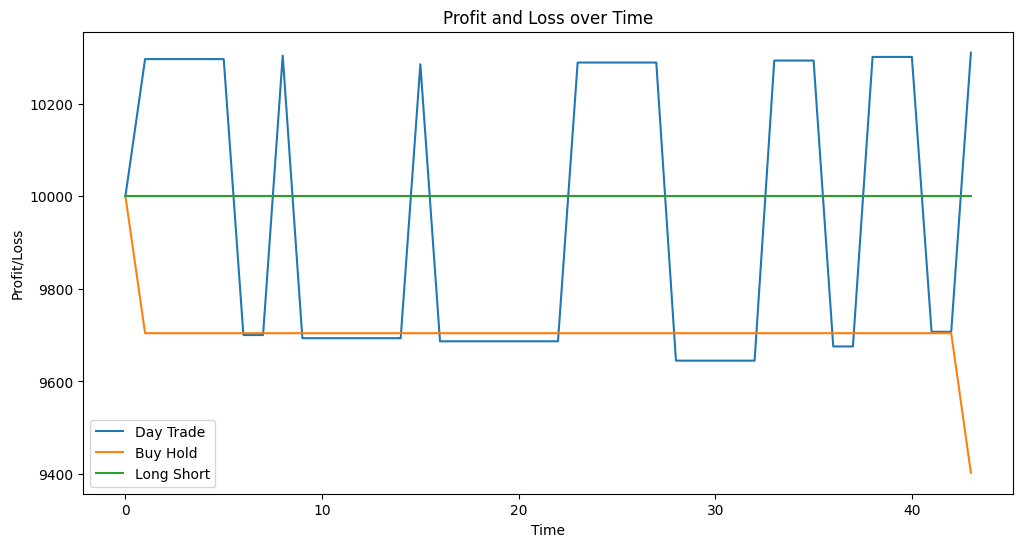

In [71]:
# Example trading signals
signal1 = TRADING_RULE(y_pred, new_y_test.values, 'DAY TRADE')
signal2 = TRADING_RULE(y_pred, new_y_test.values, 'BUY HOLD')
signal3 = TRADING_RULE(y_pred, new_y_test.values, 'LONG SHORT')

# Calculate profit and loss for each signal
profit_loss1 = calculate_profit_loss(signal1, price)
profit_loss2 = calculate_profit_loss(signal2, price)
profit_loss3 = calculate_profit_loss(signal3, price)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.plot(profit_loss1, label='Day Trade')
plt.plot(profit_loss2, label='Buy Hold')
plt.plot(profit_loss3, label='Long Short')

plt.title('Profit and Loss over Time')
plt.xlabel('Time')
plt.ylabel('Profit/Loss')
plt.legend()

plt.show()